In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker

from alive_progress import alive_bar

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

# # Defining plotting style:
plt.style.use("default")  # Dark background for plots

mpl.rcParams["grid.color"] = "grey"  # Grid color
mpl.rcParams["grid.linestyle"] = "--"  # Grid line style
mpl.rcParams["grid.linewidth"] = 0.5  # Grid line width
mpl.rcParams["grid.alpha"] = 0.5  # Grid transparency

# Setting plt colors:
# Setting plt colors to TU Delft colors (order: blue, red, yellow, green and repeating with different shades):
plt_colors = [
    "#006EB7",
    '#A50034',
    "#64A600",
    "#F97306",
    # Darker colors
    '#1A356E',
    "#E60000",
    '#6CC24A',
    '#FFB81C',
    # More darker colors
    "#000D3A",
    "#9A0000",
    "#B14400",
    "#3D5B00",
]

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Set random seed for reproducibility:
np.random.seed(42)
tf.random.set_seed(42)
# # Temporary test plot to prevent tensorflow from crashing:
# _ = plt.plot([1, 2, 3], [1, 2, 3], color=plt_colors[0])

import seaborn as sns
from scipy.signal import savgol_filter

2023-06-24 11:10:07.396470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-24 11:10:09.525496: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-24 11:10:09.525748: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-24 11:10:09.525772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Num GPUs Available:  1


2023-06-24 11:10:12.554652: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-24 11:10:12.672853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-24 11:10:12.673306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# Loading the data
telem_path = r"../../telemetry-files/funcube-1/funcube-1-telemetry-2016-02-10.h5"
telem_df = pd.read_hdf(
    telem_path,
    "telem",
)
telem_df["illumination"] = telem_df.apply(lambda row: 1 if row["theta_T (deg)"] < (360 * (1 - row["fe"])) else 0, axis=1)


# Processing telem_df for constant values:
telem_processed_df = telem_df.copy()
prev_row = telem_df.iloc[0]
for i, row in telem_df.iterrows():
    if i == 0:
        continue
    if row.iloc[6:14].equals(prev_row.iloc[6:14]):
        telem_processed_df.drop(i, inplace=True)
    prev_row = row
        
telem_processed_df = telem_processed_df.reset_index(drop=True)

telem_processed_df.head()
# Add illumination column:
# telem_processed_df["illumination"] = telem_processed_df.apply(lambda row: 1 if row["theta_T (deg)"] < (360 * (1 - row["fe"])) else 0, axis=1)

,time (utc),time (jd),beta (deg),fe,theta (deg),theta_T (deg),black chassis temperature (deg C),silver chassis temperature (deg C),black panel temperature (deg C),silver panel temperature (deg C),solar panel +X temperature (deg C),solar panel -X temperature (deg C),solar panel +Y temperature (deg C),solar panel -Y temperature (deg C),illumination
0,2016-02-04 00:00:00.000,2.457422e+06,43.419578,0.314142,287.512192,50.966681,1.23,-0.85,-2.10,2.23,3.39,-2.41,-1.40,0.43,1
1,2016-02-04 00:01:00.000,2.457423e+06,43.419238,0.313883,291.258857,54.759942,1.47,1.17,2.75,5.04,0.69,0.92,2.75,-2.91,1
2,2016-02-04 00:02:00.000,2.457423e+06,43.418972,0.313594,295.003917,58.556932,0.00,2.44,7.00,8.09,-1.80,3.84,-0.57,1.89,1
3,2016-02-04 00:03:00.000,2.457423e+06,43.418786,0.313277,298.747190,62.357285,1.68,1.81,4.38,5.67,2.97,0.50,-1.40,3.77,1
4,2016-02-04 00:04:00.000,2.457423e+06,43.418684,0.312933,302.488507,66.160507,3.65,2.77,6.23,6.31,2.14,0.50,3.79,0.22,1


In [3]:
def normalize_temperature(temps, limits=None):
    """
    Function to normalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be normalized.
    :param limits: Limits of the temperature data. If None, the limits are calculated from the data.

    :return: Normalized temperature data.
    """
    
    if limits is None:
        limits = np.array([np.min(temps), np.max(temps)])

    return (temps - limits[0]) / (limits[1] - limits[0])

def denormalize_temperature(temps, limits):
    """
    Function to denormalize the temperature data to the range [0, 1].
    :param temps: Temperature data to be denormalized.
    :param limits: Limits of the temperature data.

    :return: Denormalized temperature data.
    """

    return temps * (limits[1] - limits[0]) + limits[0]

In [4]:
# Function to calculate the kernel density estimate (KDE) of a given dataset:
def kde(data, bins=250, plot_kde=True, labels=None, plt_title=None):
    """
    Function to calculate the kernel density estimate (KDE) of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param bins: Number of bins to be used for the KDE.
    :param plot_kde: Boolean to plot the KDE.
    :param labels: Labels of the KDE plots.

    :return: kde, bin_centers
    """

    kde = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the KDE values
    bin_centers = np.empty(shape=(data.shape[1], bins), dtype=np.float64)   # array to store the bin centers
    for i in range(data.shape[1]):
        kde_func = gaussian_kde(data[:, i])  # kernel density estimate function
        bin_centers[i] = np.linspace(np.min(data[:, i]), np.max(data[:, i]), bins)  # bin centers
        kde[i, :] = kde_func(bin_centers[i])    # KDE values

    if plot_kde:
        plt.figure(figsize=(6, 5), tight_layout=True)
        for i in range(data.shape[1]):
            plt.plot(
                bin_centers[i],
                kde[i],
                color=plt_colors[i],
                label=labels[i] if labels is not None else None,
            )

        plt.xlabel(r"Error ($^\circ$C)")
        plt.ylabel(r"Probability density ($^\circ$C$^{-1}$)")
        if plt_title is None:
            plt_title = "Kernel density estimate of the errors"
        plt.title(plt_title)
        plt.legend()
        plt.grid()
        plt.show()

    return kde, bin_centers



def print_kde_stats(data, kde, bin_centers):
    """
    Function to print the mean, standard deviation and area under the KDE curve of a given dataset.
    :param data: Dataset to be used for the KDE.
    :param kde: KDE values.
    :param bin_centers: Bin centers.

    :return: None
    """

    print("Battery:")
    print(f"Mean: {np.mean(data[:, 0]):.2f} degC Std: {np.std(data[:, 0]):.2f} degC (area: {np.trapz(kde[0], bin_centers[0]):.2f})")
    print("Solar panel Yp:")
    print(f"Mean: {np.mean(data[:, 1]):.2f} degC Std: {np.std(data[:, 1]):.2f} degC (area: {np.trapz(kde[1], bin_centers[1]):.2f})")
    print("Solar panel Ym:")
    print(f"Mean: {np.mean(data[:, 2]):.2f} degC Std: {np.std(data[:, 2]):.2f} degC (area: {np.trapz(kde[2], bin_centers[2]):.2f})")
    print("Solar panel Xp:")
    print(f"Mean: {np.mean(data[:, 3]):.2f} degC Std: {np.std(data[:, 3]):.2f} degC (area: {np.trapz(kde[3], bin_centers[3]):.2f})")
    print("Solar panel Xm:")
    print(f"Mean: {np.mean(data[:, 4]):.2f} degC Std: {np.std(data[:, 4]):.2f} degC (area: {np.trapz(kde[4], bin_centers[4]):.2f})")
    print("MCU:")
    print(f"Mean: {np.mean(data[:, 5]):.2f} degC Std: {np.std(data[:, 5]):.2f} degC (area: {np.trapz(kde[5], bin_centers[5]):.2f})")


In [5]:
def plot_model(
    theta_T_vals,
    temp_vals,
    plt_titles=None,
    labels=None,
    colors=None,
    plt_scatter=None,
    linestyles=None,
    limits=None,
    plt_suptitle=None,
):
    """Plots the temperature values of the model.

    Parameters
    ----------
    theta_T_vals : list of numpy.ndarray
        List of theta_T values for each model.
    temp_vals : list of numpy.ndarray
        List of temperature values for each model.
    plt_titles : list of str, optional
        List of titles for each subplot, by default None
    labels : list of str, optional
        List of labels for each model, by default None
    colors : list of mpl colors, optional
        List of colors for each model, by default None
    plt_scatter : list of bool, optional
        List of bools to indicate if the model should be plotted as a scatter plot, by default None
    linestyles : list of str, optional
        List of linestyles for each model, by default None
    limits : list of list of float, optional
        List of limits for each axis, by default None
    plt_suptitle : str, optional
        Title for the figure, by default None
    """

    plt_rows = 2
    plt_cols = 4

    fig, ax = plt.subplots(plt_rows, plt_cols, figsize=(plt_cols * 5, plt_rows * 5))

    for i in range(plt_rows):
        for j in range(plt_cols):
            for k in range(len(theta_T_vals)):
                if plt_scatter[k]:
                    ax[i, j].scatter(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        s=2,
                    )
                else:
                    ax[i, j].plot(
                        theta_T_vals[k],
                        temp_vals[k][:, i * plt_cols + j],
                        label=labels[k] if labels is not None else None,
                        color=colors[k] if colors is not None else plt_colors[k],
                        linestyle=linestyles[k] if linestyles is not None else "-",
                    )

            ax[i, j].set_xlabel(r"$\theta_T$ (deg)")
            ax[i, j].set_ylabel("Temperature (deg C)")
            ax[i, j].set_title(plt_titles[i * plt_cols + j] if plt_titles is not None else None)
            ax[i, j].legend(fontsize=8)
            if limits is not None:
                ax[i, j].set_xlim(limits[0])
                ax[i, j].set_ylim(limits[1])

            ax[i, j].grid()

    if plt_suptitle is not None:
        fig.suptitle(plt_suptitle, fontsize=12)

    return fig, ax

In [6]:
# Test/train split
train_df = telem_processed_df.iloc[:int(0.8 * len(telem_processed_df))].reset_index(drop=True)
test_df = telem_processed_df.iloc[int(0.8 * len(telem_processed_df)):].reset_index(drop=True)

train_norm_df = train_df.copy()
norm_limits = [np.min(train_norm_df.iloc[:, 6:-1].to_numpy()), np.max(train_norm_df.iloc[:, 6:-1].to_numpy())]
train_norm_df.iloc[:, 6:-1] = normalize_temperature(train_norm_df.iloc[:, 6:-1].to_numpy(), norm_limits)

test_norm_df = test_df.copy()
test_norm_df.iloc[:, 6:-1] = normalize_temperature(test_norm_df.iloc[:, 6:-1].to_numpy(), norm_limits)

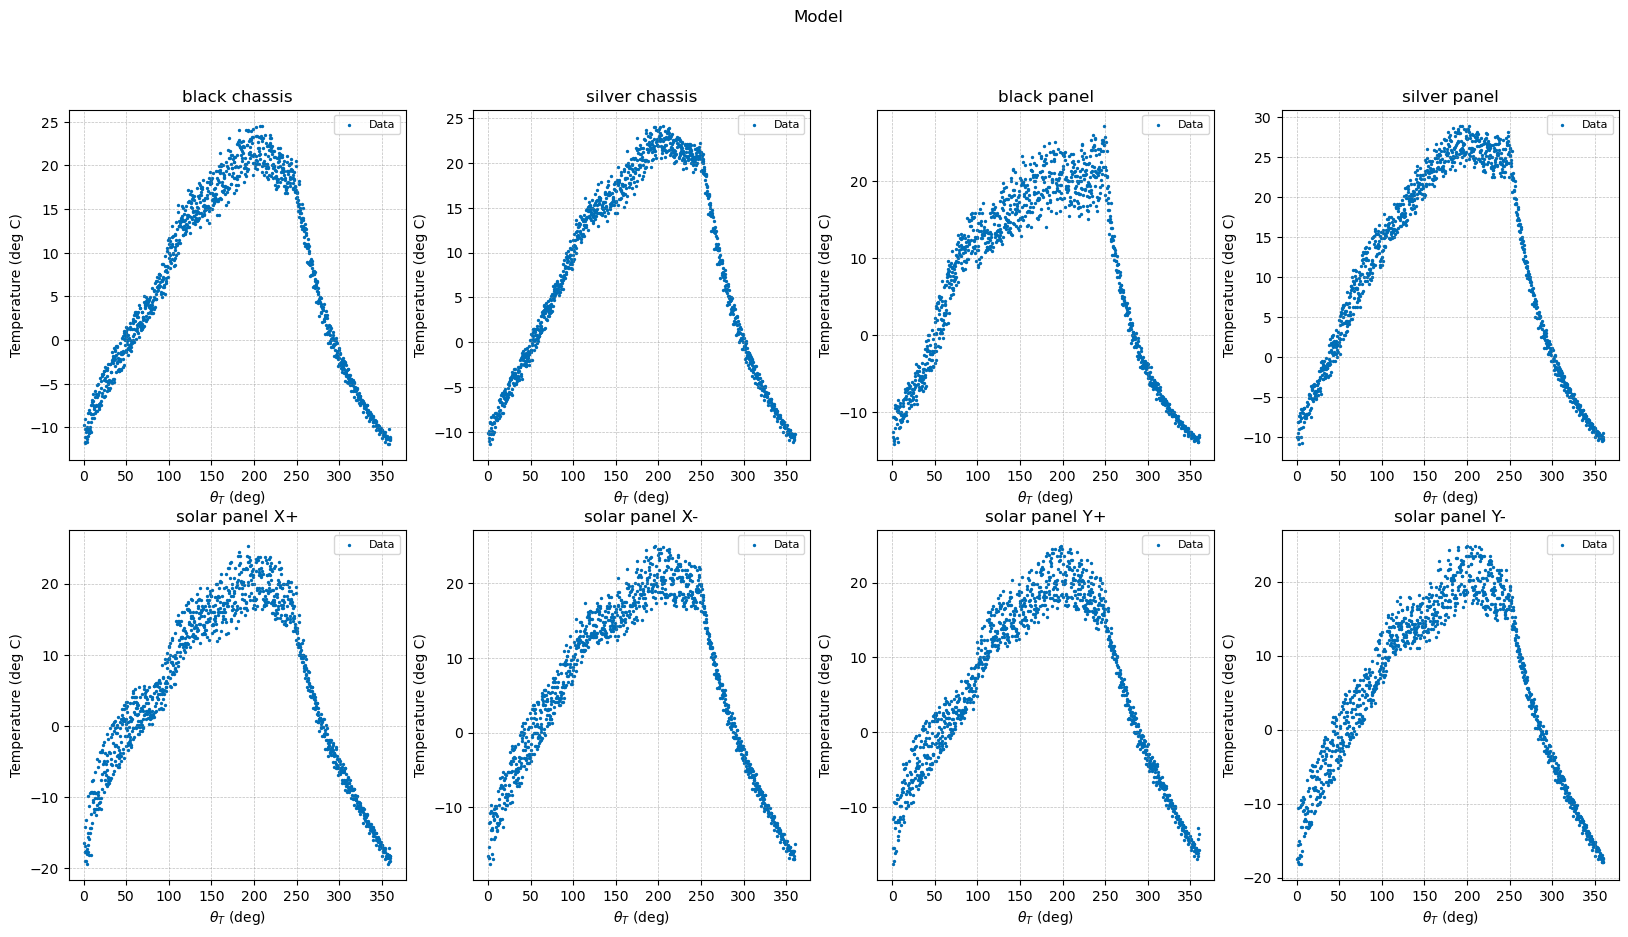

In [7]:
theta_T_vals = [telem_processed_df["theta_T (deg)"]]
temp_vals = [telem_processed_df.iloc[:, 6:-1].to_numpy()]
plt_titles = ["black chassis", "silver chassis", "black panel", "silver panel", "solar panel X+", "solar panel X-", "solar panel Y+", "solar panel Y-"]

fig, ax = plot_model(theta_T_vals, temp_vals, plt_suptitle="Model", plt_scatter=[True], plt_titles=plt_titles, labels=["Data"])

In [8]:
# Anomaly df
anomaly_df = telem_df.iloc[350:575, :]
anomaly_df = anomaly_df.copy().reset_index(drop=True)
anomaly_norm_df = anomaly_df.copy()
anomaly_norm_df.iloc[:, 6:-1] = normalize_temperature(anomaly_df.iloc[:, 6:], norm_limits)


In [9]:
class Model:
    """
    Class to hold the model and its training and testing data.

    :param train_x: Training input data.
    :param train_y: Training output data.
    :param test_x: Testing input data.
    :param test_y: Testing output data.
    :param name: Name of the model.
    :param model: Tensorflow model.
    :param run_device: Device to run the model on.
    :param history: History of the model training.
    """

    def __init__(self, train_x, train_y, test_x, test_y, name=None):
        """
        Initialize the model class.
        :param train_x: Training input data.
        :param train_y: Training output data.
        :param test_x: Testing input data.
        :param test_y: Testing output data.
        :param name: Name of the model.

        :return: None
        """

        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.name = name
        self.model = None
        self.run_device = None
        self.history = None


    def create_model(self, layers, optimizer, loss, metrics, input_shape, output_shape):
        """
        Create the model.
        :param layers: List of layers stored as dictionaries with the following keys: type, units, activation.
        :param optimizer: Optimizer function to use for trining.
        :param loss: Loss function to use for training.
        :param metrics: Metrics to use for training.
        :param input_shape: Shape of the input data.
        :param output_shape: Shape of the output data.

        :return: None
        """

        self.model = tf.keras.Sequential(name=self.name)    # create the model
        self.model.add(tf.keras.layers.InputLayer(input_shape=input_shape))   # add the input layer
        self.run_device = "/GPU:0"  # set the device to run the model on

        # Add the layers to the model
        for i, layer in enumerate(layers):
            if layer.get("type") == "LSTM":
                if i < len(layers) - 1:
                    if layers[i + 1].get("type") == "LSTM":
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=True,
                            )
                        )
                    else:
                        self.model.add(
                            tf.keras.layers.LSTM(
                                layer.get("units"),
                                activation=layer.get("activation"),
                                return_sequences=False,
                            )
                        )
                else:
                    self.model.add(
                        tf.keras.layers.LSTM(
                            layer.get("units"),
                            activation=layer.get("activation"),
                            return_sequences=False,
                        )
                    )
                if layer.get("activation") == "relu":
                    self.run_device = "/CPU:0"  # if the model uses a ReLU activation function, run it on the CPU
            elif layer.get("type") == "Dense":
                self.model.add(
                    tf.keras.layers.Dense(
                        layer.get("units"), activation=layer.get("activation"),
                    )
                )
            else:
                raise ValueError("Invalid layer type")  # raise an error if the layer type is invalid

        self.model.add(tf.keras.layers.Dense(output_shape, activation="linear"))    # add the output layer

        # Compile the model
        self.model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=[metrics],
        )

    
    def train_model(self, epochs, callbacks=None, batch_size=100, plot_train_history=True, verbose=True):
        """
        Function to train the model.
        :param epochs: Number of epochs to train the model for.
        :param callbacks: Callbacks to use during training.

        :return: None
        """
        if self.test_x is None or self.test_y is None:
            monitor_val_loss = False
        else:
            monitor_val_loss = True
        # Train the model
        with tf.device(self.run_device):
            if monitor_val_loss:
                self.history = self.model.fit(
                    self.train_x,
                    self.train_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(self.test_x, self.test_y),
                    callbacks=[callbacks],
                    verbose=verbose,
                )
            else:
                self.history = self.model.fit(
                    self.train_x,
                    self.train_y,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callbacks],
                    verbose=verbose,
                )

        # Plot the training history
        if plot_train_history:
            plt.figure(figsize=(5, 5))
            plt.plot(
                np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
                self.history.history["loss"],
                color=plt_colors[0],
                label="Training Loss",
            )
            if monitor_val_loss:
                plt.plot(
                    np.linspace(1, len(self.history.history["loss"]), len(self.history.history["loss"])),
                    self.history.history["val_loss"],
                    color=plt_colors[1],
                    label="Validation Loss",
                )
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(self.name)
            plt.legend()
            plt.grid()
            plt.show()

## Temperature based models

In [10]:
def window_data_base_temp(df, window_size, check_continuous=True):
    df = df.copy()
    columns = np.concatenate((
        ["theta_T"],
        ["black panel " + str(i) for i in range(window_size)],
        ["black panel out"]
    ))

    window_df = pd.DataFrame(columns=columns, dtype=np.float64)

    with alive_bar(df.shape[0] - window_size, theme="classic", force_tty=True) as bar:
        for i in range(df.shape[0] - window_size):
            if check_continuous and (df.loc[i+window_size, "time (jd)"] - df.loc[i, "time (jd)"] > 1.25 * (i * 24 * 60)):
                bar()
                continue
            
            window_df.loc[i, "theta_T"] = df.loc[i+window_size, "theta_T (deg)"]
            window_df.loc[i, "black panel 0":"black panel "+str(window_size-1)] = df.loc[i:i+window_size-1, "black panel temperature (deg C)"].to_numpy()
            window_df.loc[i, "black panel out"] = df.loc[i+window_size, "black panel temperature (deg C)"]
            bar()
            
    x = np.zeros((window_df.shape[0], window_size), dtype=np.float64)
    y = np.zeros((window_df.shape[0], 1), dtype=np.float64)
    
    x = window_df.iloc[:, 1:-1].to_numpy()
    y = window_df.iloc[:, -1].to_numpy()
            

    return window_df, x.reshape(-1, window_size, 1), y

In [11]:
base_model_layers = np.empty(shape=(7), dtype=dict,)    # create an array to hold the layers of the base model
base_model_layers[0] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[1] = {
    "type": "LSTM",
    "units": 256,
    "activation": "tanh",
}
base_model_layers[2] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[3] = {
    "type": "LSTM",
    "units": 128,
    "activation": "tanh",
}
base_model_layers[4] = {
    "type": "LSTM",
    "units": 64,
    "activation": "tanh",
}
base_model_layers[5] = {
    "type": "LSTM",
    "units": 32,
    "activation": "tanh",
}
base_model_layers[6] = {
    "type": "LSTM",
    "units": 16,
    "activation": "tanh",
}

base_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
    min_delta=1e-4
)   # early stopping callback

[========================================] 932/932 [100%] in 1.3s (719.92/s)                                            
[========================================] 232/232 [100%] in 0.3s (712.20/s)                                            
Epoch 1/500
10/10 [==============================] - 17s 361ms/step - loss: 0.3574 - mean_absolute_error: 0.5429 - val_loss: 0.3445 - val_mean_absolute_error: 0.5352
Epoch 2/500
10/10 [==============================] - 0s 23ms/step - loss: 0.3524 - mean_absolute_error: 0.5382 - val_loss: 0.3394 - val_mean_absolute_error: 0.5305
Epoch 3/500
10/10 [==============================] - 0s 23ms/step - loss: 0.3472 - mean_absolute_error: 0.5333 - val_loss: 0.3340 - val_mean_absolute_error: 0.5254
Epoch 4/500
10/10 [==============================] - 0s 23ms/step - loss: 0.3416 - mean_absolute_error: 0.5281 - val_loss: 0.3284 - val_mean_absolute_error: 0.5200
Epoch 5/500
10/10 [==============================] - 0s 24ms/step - loss: 0.3357 - mean_absolute_err

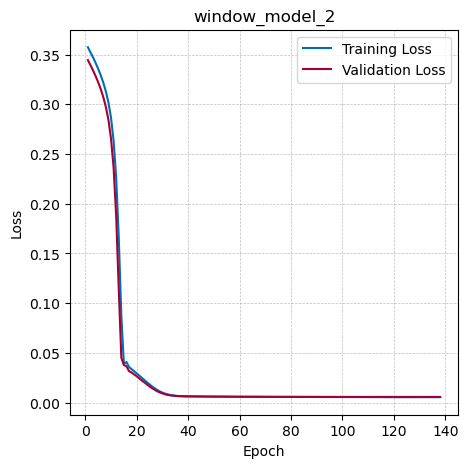

[========================================] 929/929 [100%] in 1.2s (816.62/s)                                            
[========================================] 229/229 [100%] in 0.3s (803.55/s)                                            
Epoch 1/500
10/10 [==============================] - 17s 353ms/step - loss: 0.3555 - mean_absolute_error: 0.5409 - val_loss: 0.3353 - val_mean_absolute_error: 0.5268
Epoch 2/500
10/10 [==============================] - 0s 24ms/step - loss: 0.3445 - mean_absolute_error: 0.5307 - val_loss: 0.3236 - val_mean_absolute_error: 0.5157
Epoch 3/500
10/10 [==============================] - 0s 23ms/step - loss: 0.3314 - mean_absolute_error: 0.5184 - val_loss: 0.3088 - val_mean_absolute_error: 0.5014
Epoch 4/500
10/10 [==============================] - 0s 23ms/step - loss: 0.3139 - mean_absolute_error: 0.5018 - val_loss: 0.2876 - val_mean_absolute_error: 0.4805
Epoch 5/500
10/10 [==============================] - 0s 23ms/step - loss: 0.2875 - mean_absolute_err

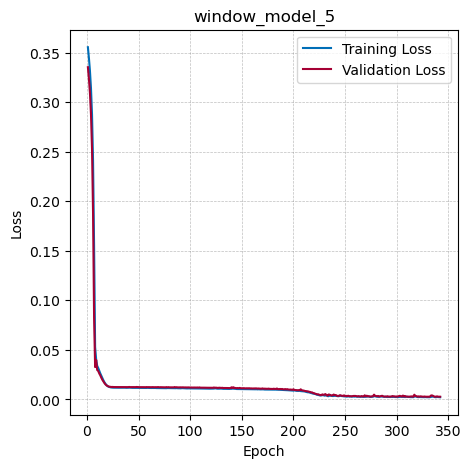

[========================================] 924/924 [100%] in 1.2s (754.05/s)                                            
[========================================] 224/224 [100%] in 0.3s (870.76/s)                                            
Epoch 1/500
10/10 [==============================] - 18s 384ms/step - loss: 0.3427 - mean_absolute_error: 0.5294 - val_loss: 0.3067 - val_mean_absolute_error: 0.4993
Epoch 2/500
10/10 [==============================] - 0s 25ms/step - loss: 0.2979 - mean_absolute_error: 0.4870 - val_loss: 0.2492 - val_mean_absolute_error: 0.4416
Epoch 3/500
10/10 [==============================] - 0s 26ms/step - loss: 0.2224 - mean_absolute_error: 0.4071 - val_loss: 0.1456 - val_mean_absolute_error: 0.3186
Epoch 4/500
10/10 [==============================] - 0s 25ms/step - loss: 0.0951 - mean_absolute_error: 0.2567 - val_loss: 0.0337 - val_mean_absolute_error: 0.1698
Epoch 5/500
10/10 [==============================] - 0s 23ms/step - loss: 0.0409 - mean_absolute_err

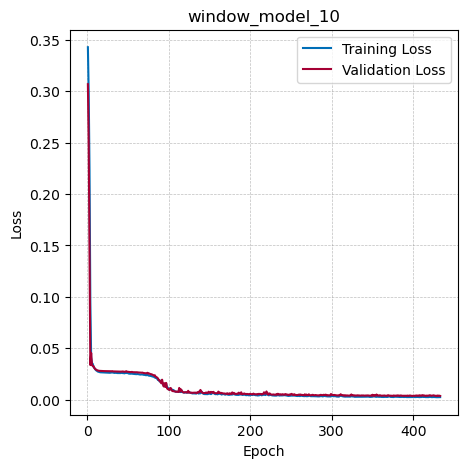

[========================================] 904/904 [100%] in 1.2s (741.79/s)                                            
[========================================] 204/204 [100%] in 0.3s (855.87/s)                                            
Epoch 1/500
10/10 [==============================] - 18s 435ms/step - loss: 0.3065 - mean_absolute_error: 0.4915 - val_loss: 0.2224 - val_mean_absolute_error: 0.4038
Epoch 2/500
10/10 [==============================] - 0s 36ms/step - loss: 0.1387 - mean_absolute_error: 0.3159 - val_loss: 0.0792 - val_mean_absolute_error: 0.2468
Epoch 3/500
10/10 [==============================] - 0s 35ms/step - loss: 0.0907 - mean_absolute_error: 0.2363 - val_loss: 0.0747 - val_mean_absolute_error: 0.2313
Epoch 4/500
10/10 [==============================] - 0s 37ms/step - loss: 0.0700 - mean_absolute_error: 0.2351 - val_loss: 0.0681 - val_mean_absolute_error: 0.2429
Epoch 5/500
10/10 [==============================] - 0s 38ms/step - loss: 0.0664 - mean_absolute_err

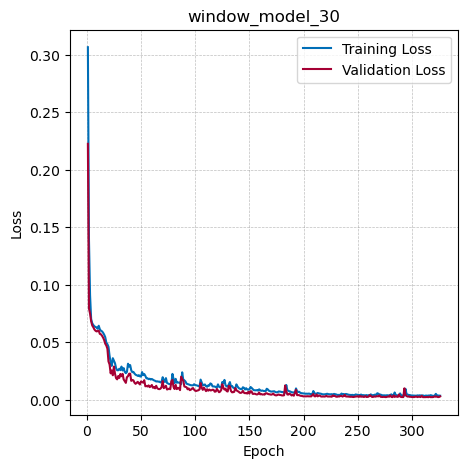

[========================================] 874/874 [100%] in 1.4s (637.64/s)                                            
[========================================] 174/174 [100%] in 0.3s (697.60/s)                                            
Epoch 1/500
9/9 [==============================] - 20s 458ms/step - loss: 0.3077 - mean_absolute_error: 0.4927 - val_loss: 0.1945 - val_mean_absolute_error: 0.3627
Epoch 2/500
9/9 [==============================] - 0s 54ms/step - loss: 0.1390 - mean_absolute_error: 0.3174 - val_loss: 0.1038 - val_mean_absolute_error: 0.2814
Epoch 3/500
9/9 [==============================] - 0s 52ms/step - loss: 0.0862 - mean_absolute_error: 0.2445 - val_loss: 0.0745 - val_mean_absolute_error: 0.2426
Epoch 4/500
9/9 [==============================] - 0s 53ms/step - loss: 0.0650 - mean_absolute_error: 0.2326 - val_loss: 0.0609 - val_mean_absolute_error: 0.2251
Epoch 5/500
9/9 [==============================] - 0s 53ms/step - loss: 0.0643 - mean_absolute_error: 0.2322

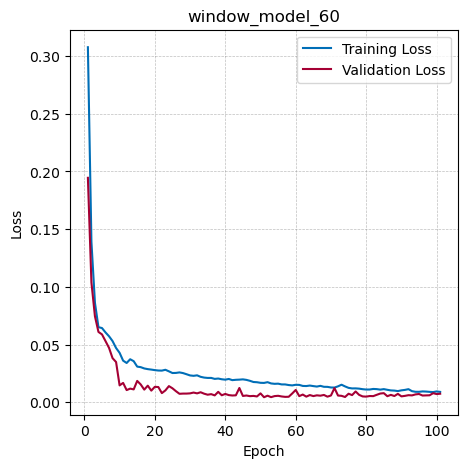

[========================================] 839/839 [100%] in 1.4s (612.91/s)                                            
[========================================] 139/139 [100%] in 0.2s (748.71/s)                                            
Epoch 1/500
9/9 [==============================] - 18s 468ms/step - loss: 0.2574 - mean_absolute_error: 0.4364 - val_loss: 0.1261 - val_mean_absolute_error: 0.3120
Epoch 2/500
9/9 [==============================] - 1s 74ms/step - loss: 0.0847 - mean_absolute_error: 0.2564 - val_loss: 0.0732 - val_mean_absolute_error: 0.2211
Epoch 3/500
9/9 [==============================] - 1s 73ms/step - loss: 0.0686 - mean_absolute_error: 0.2284 - val_loss: 0.0543 - val_mean_absolute_error: 0.2119
Epoch 4/500
9/9 [==============================] - 1s 73ms/step - loss: 0.0632 - mean_absolute_error: 0.2301 - val_loss: 0.0505 - val_mean_absolute_error: 0.2016
Epoch 5/500
9/9 [==============================] - 1s 72ms/step - loss: 0.0605 - mean_absolute_error: 0.2196

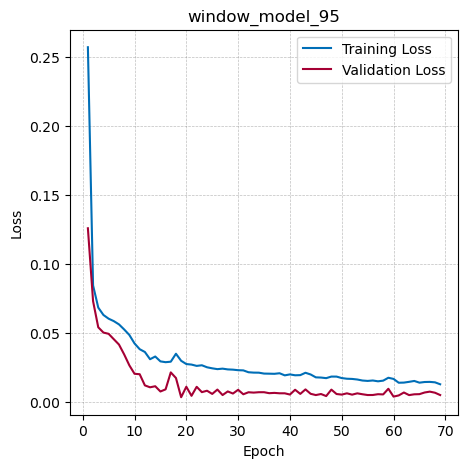

In [14]:
# window_sizes = [2, 5, 10, 15, 20, 25, 30, 40, 50, 60, 64, 68, 70, 80, 90, 94, 95, 96, 97, 100, 110, 120]
window_sizes = [2, 5, 10, 30, 60, 95]
temp_models = []

for window_size in window_sizes:
    train_window_df, train_x, train_y = window_data_base_temp(train_norm_df, window_size)
    test_window_df, test_x, test_y = window_data_base_temp(test_norm_df, window_size)
    temp_model = Model(train_x, train_y, test_x, test_y, name=f"window_model_{window_size}")
    temp_model.create_model(
        base_model_layers,
        tf.keras.optimizers.Adam(learning_rate=1e-4),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
        input_shape=(None, 1),
        output_shape=1,
    )
    # temp_model.run_device = "/CPU:0"

    temp_model.train_model(epochs=500, callbacks=base_early_stopping)
    temp_models.append(temp_model.model)

In [15]:
mu = np.zeros((len(temp_models)), dtype=np.float64)
sigma = np.zeros((len(temp_models)), dtype=np.float64)
for i, model in enumerate(temp_models):
    _, test_x, test_y = window_data_base_temp(test_norm_df, window_sizes[i])
    actual = denormalize_temperature(test_y, norm_limits)
    predicted = denormalize_temperature(model.predict(test_x, verbose=0).flatten(), norm_limits)
    error = actual - predicted
    _ = kde(error.reshape(-1, 1), labels=[""], plot_kde=False)
    mu[i] = np.mean(error)
    sigma[i] = np.std(error)

[                                        ] - 2/232 [1%] in 0s (~0s, 817.5/s) 

[========================================] 232/232 [100%] in 0.4s (737.95/s)                                            
[========================================] 229/229 [100%] in 0.3s (759.40/s)                                            
[========================================] 224/224 [100%] in 0.3s (759.63/s)                                            
[========================================] 204/204 [100%] in 0.3s (713.90/s)                                            
[========================================] 174/174 [100%] in 0.2s (780.17/s)                                            
[========================================] 139/139 [100%] in 0.2s (686.63/s)                                            


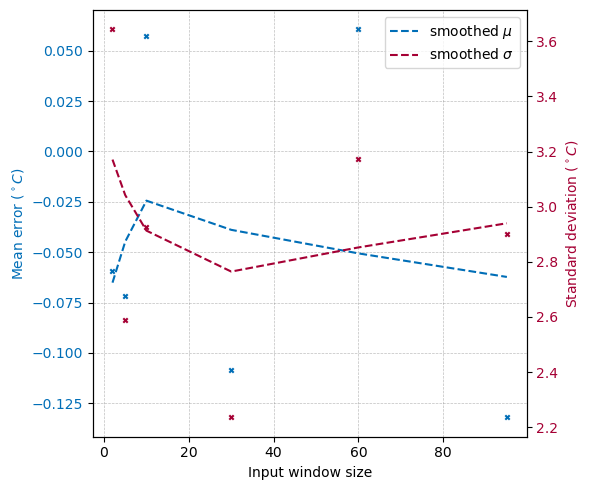

In [16]:
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
ax.scatter(window_sizes, mu, s=10, color=plt_colors[0], marker="x")
# smoothed line
ax.plot(window_sizes, savgol_filter(mu, 5, 1), color=plt_colors[0], linestyle="--", label="smoothed $\mu$")
twin_ax = ax.twinx()
twin_ax.scatter(window_sizes, sigma, s=10, color=plt_colors[1], marker="x")
# smoothed line
twin_ax.plot(window_sizes, savgol_filter(sigma, 5, 1), color=plt_colors[1], linestyle="--", label="smoothed $\sigma$")

# combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = twin_ax.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)
ax.set_ylabel(r"Mean error ($^\circ C$)", color=plt_colors[0])
twin_ax.set_ylabel(r"Standard deviation ($^\circ C$)", color=plt_colors[1])
ax.tick_params(axis="y", labelcolor=plt_colors[0])
twin_ax.tick_params(axis="y", labelcolor=plt_colors[1])
ax.set_xlabel("Input window size")
ax.grid()

plt.show()

In [37]:
print(mu)
print(sigma)

[-0.05952976 -0.07189751  0.05742813 -0.10862642  0.06060767 -0.13195889]
[3.64291387 2.5874766  2.92462106 2.23601334 3.17451875 2.90052443]


In [17]:
print([[i, window_size] for i, window_size in enumerate(window_sizes)])

[[0, 2], [1, 5], [2, 10], [3, 30], [4, 60], [5, 95]]


In [33]:
plt.rcParams.update({'font.size': 16})

[========================================] 232/232 [100%] in 0.3s (794.64/s)                                            
Window size: 2
[========================================] 229/229 [100%] in 0.5s (502.09/s)                                            
Window size: 5
[========================================] 224/224 [100%] in 0.5s (491.93/s)                                            
Window size: 10
[========================================] 204/204 [100%] in 0.3s (704.55/s)                                            
Window size: 30
[========================================] 174/174 [100%] in 0.2s (796.68/s)                                            
Window size: 60
[========================================] 139/139 [100%] in 0.2s (837.46/s)                                            
Window size: 95


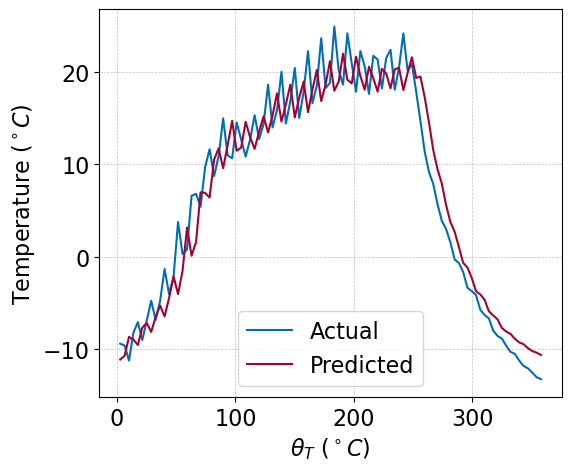

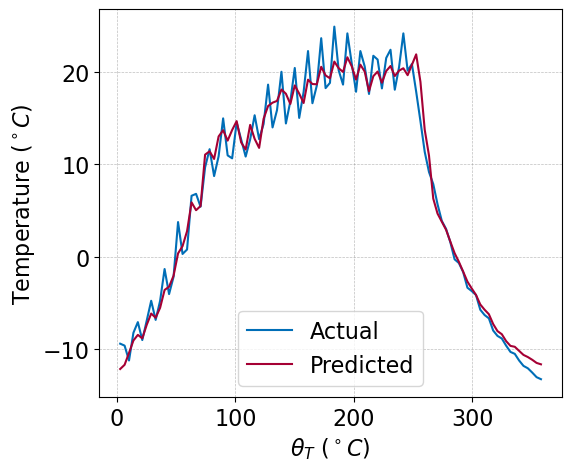

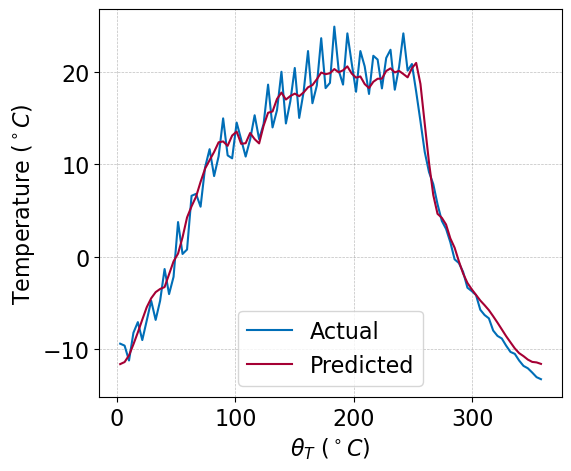

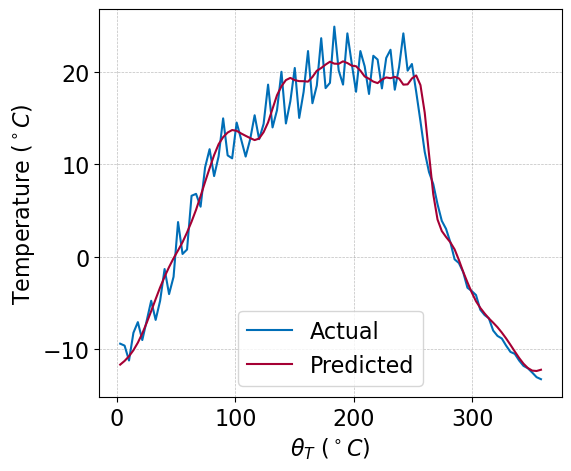

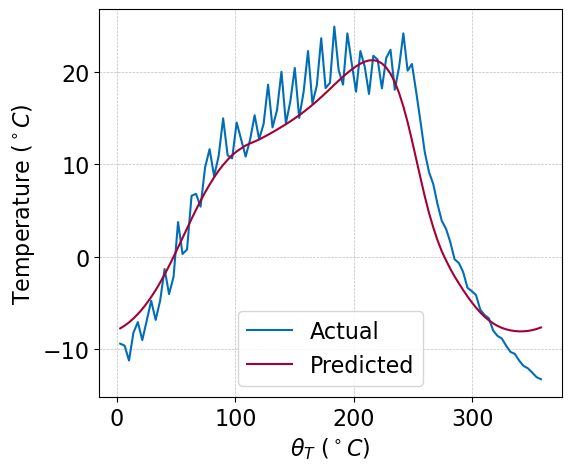

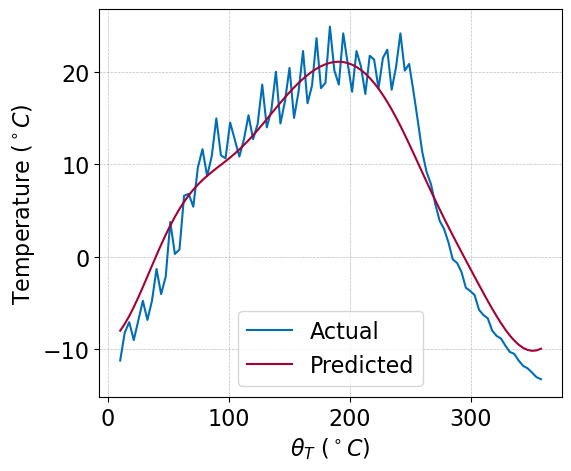

In [34]:
plot_idxs = [0, 1, 2, 3, 4, 5]
# plot_idxs = [0]
for idx in plot_idxs:
    model = temp_models[idx]
    test_window_df, test_x, test_y = window_data_base_temp(test_norm_df, window_sizes[idx])
    test_window_df = test_window_df.reset_index(drop=True)
    theta_T = test_window_df.iloc[:, 0].to_numpy()
    actual = test_y
    predicted = model.predict(test_x, verbose=0).flatten()
    actual = denormalize_temperature(actual, norm_limits)
    predicted = denormalize_temperature(predicted, norm_limits)
    window_size = window_sizes[idx]
    print(f"Window size: {window_size}")

    try:
        start_index = test_window_df[test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][94]].index[0]
    except:
        start_index = 0
        
    end_index = test_window_df[test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][190]].index[0] + 1
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.plot(theta_T[start_index:end_index], actual[start_index:end_index], color=plt_colors[0], label="Actual")
    ax.plot(theta_T[start_index:end_index], predicted[start_index:end_index], color=plt_colors[1], label="Predicted")
    ax.set_xlabel(r"$\theta_T$ ($^\circ C$)")
    ax.set_ylabel(r"Temperature ($^\circ C$)")
    ax.legend()
    ax.grid()

    fig.savefig(f"../../report/images/chapter-4/funcube-black-panel-temp-lstm-window-{window_size}.pdf")

[========================================] 223/223 [100%] in 0.3s (725.70/s)                                            
[========================================] 215/215 [100%] in 0.3s (748.60/s)                                            
[========================================] 165/165 [100%] in 0.2s (848.32/s)                                            


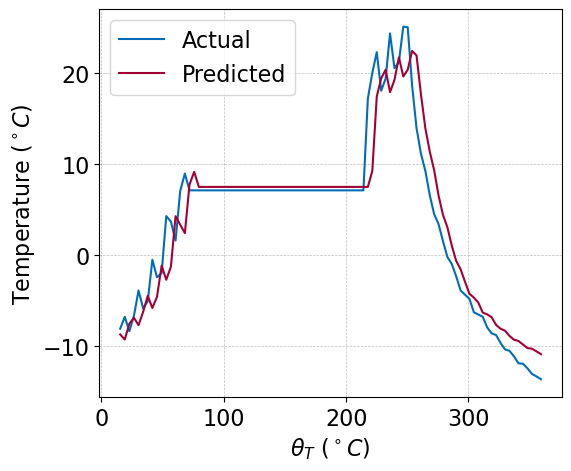

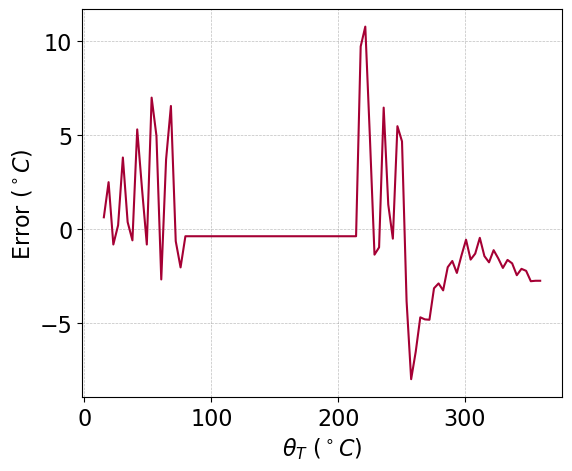

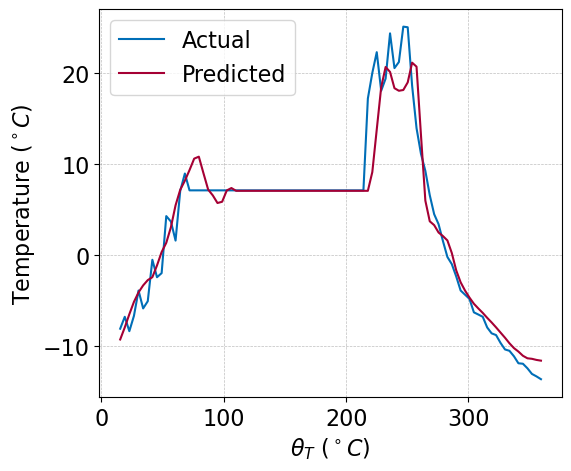

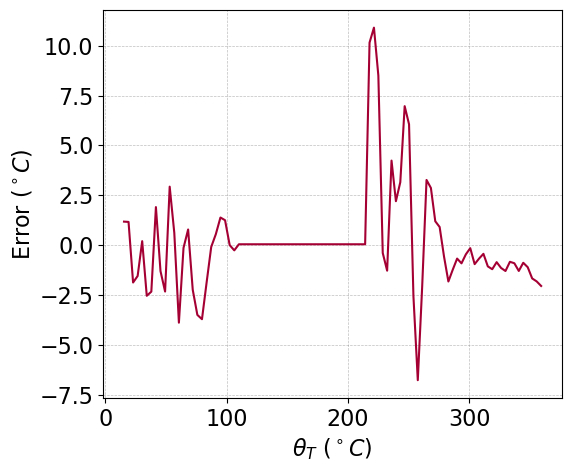

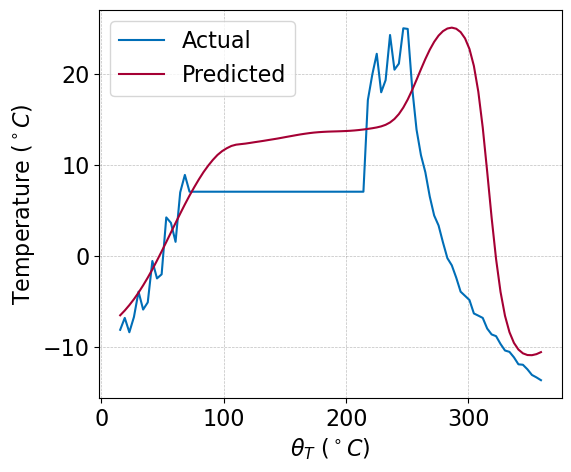

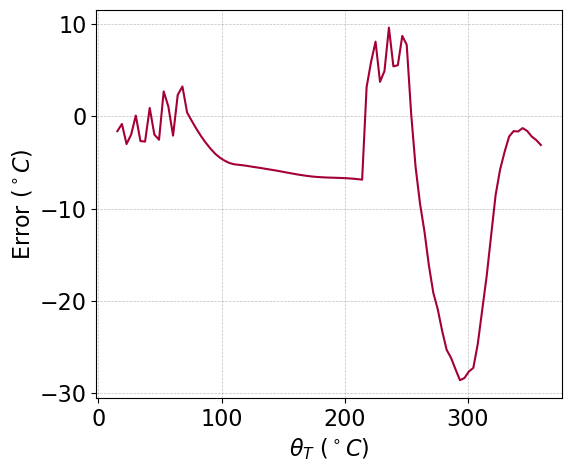

In [35]:
plot_idxs = [0, 2, 4]
anomaly_mu = np.zeros((len(plot_idxs), 3))
anomaly_sigma = np.zeros((len(plot_idxs), 3))
for j, idx in enumerate(plot_idxs):
    window_size = window_sizes[idx]
    anomaly_windowed_df, anomaly_x, anomaly_y = window_data_base_temp(anomaly_norm_df, window_sizes[idx])
    theta_T = anomaly_windowed_df.iloc[:, 0].to_numpy()
    actual = denormalize_temperature(anomaly_y, norm_limits)
    predicted = denormalize_temperature(temp_models[idx].predict(anomaly_x, verbose=0).flatten(), norm_limits)
    try:
        start_index = anomaly_windowed_df[anomaly_windowed_df["theta_T"] == anomaly_df["theta_T (deg)"][127]].index[0]
    except:
        start_index = 0
    end_index = anomaly_windowed_df[anomaly_windowed_df["theta_T"] == anomaly_df["theta_T (deg)"][221]].index[0]
    anomaly_start_theta_T = anomaly_df["theta_T (deg)"][143]
    anomaly_end_theta_T = anomaly_df["theta_T (deg)"][181]
    anomaly_start_idx = anomaly_windowed_df[anomaly_windowed_df["theta_T"] == anomaly_start_theta_T].index[0]
    anomaly_end_idx = anomaly_windowed_df[anomaly_windowed_df["theta_T"] == anomaly_end_theta_T].index[0]
    error = actual - predicted
    
    anomaly_mu[j] = np.nanmean(error[:anomaly_start_idx]), np.nanmean(error[anomaly_start_idx:anomaly_end_idx]), np.nanmean(error[anomaly_end_idx:])
    anomaly_sigma[j] = np.nanstd(error[:anomaly_start_idx]), np.nanstd(error[anomaly_start_idx:anomaly_end_idx]), np.nanstd(error[anomaly_end_idx:])
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.plot(theta_T[start_index:end_index], actual[start_index:end_index], color=plt_colors[0], label="Actual")
    ax.plot(theta_T[start_index:end_index], predicted[start_index:end_index], color=plt_colors[1], label="Predicted")
    ax.set_xlabel(r"$\theta_T$ ($^\circ C$)")
    ax.set_ylabel(r"Temperature ($^\circ C$)")
    ax.legend()
    ax.grid()
    
    fig.savefig(f"../../report/images/chapter-4/funcube-black-panel-temp-anomaly-window-{window_size}.pdf")
    
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.plot(theta_T[start_index:end_index], error[start_index:end_index], color=plt_colors[1])
    ax.set_xlabel(r"$\theta_T$ ($^\circ C$)")
    ax.set_ylabel(r"Error ($^\circ C$)")
    ax.grid()
    
    fig.savefig(f"../../report/images/chapter-4/funcube-black-panel-temp-anomaly-window-{window_size}-error.pdf")

In [32]:
print(np.round(anomaly_mu, 2))
print(np.round(anomaly_sigma, 2))

[[-0.03 -0.42 -0.88]
 [-0.04 -0.12  0.63]
 [ 1.37 -5.45 -8.03]]
[[ 3.03  0.27  3.74]
 [ 1.89  0.93  3.46]
 [ 4.03  1.53 12.22]]


## Illumination based models

In [38]:
def window_data_base_illumination(df, window_size, check_continuous=True):
    df = df.copy()
    columns = np.concatenate((
        ["theta_T"],
        ["illumination " + str(i) for i in range(window_size)],
        ["black panel out"]
    ))

    window_df = pd.DataFrame(columns=columns, dtype=np.float64)

    with alive_bar(df.shape[0] - window_size, theme="classic", force_tty=True) as bar:
        for i in range(df.shape[0] - window_size):
            if check_continuous and (df.loc[i+window_size, "time (jd)"] - df.loc[i, "time (jd)"] > 1.25 * (i * 24 * 60)):
                bar()
                continue
            
            window_df.loc[i, "theta_T"] = df.loc[i+window_size, "theta_T (deg)"]
            window_df.loc[i, "illumination 0":"illumination "+str(window_size-1)] = df.loc[i:i+window_size-1, "illumination"].to_numpy()
            window_df.loc[i, "black panel out"] = df.loc[i+window_size, "black panel temperature (deg C)"]
            bar()
            
    x = np.zeros((window_df.shape[0], window_size), dtype=np.float64)
    y = np.zeros((window_df.shape[0], 1), dtype=np.float64)
    
    x = window_df.iloc[:, 1:-1].to_numpy()
    y = window_df.iloc[:, -1].to_numpy()
            

    return window_df, x.reshape(-1, window_size, 1), y

[                                        ] - 8/904 [1%] in 0s (~1s, 673.0/s) 

[========================================] 904/904 [100%] in 1.5s (605.17/s)                                            
[========================================] 204/204 [100%] in 0.3s (698.11/s)                                            
Epoch 1/500
10/10 [==============================] - 19s 614ms/step - loss: 0.2786 - mean_absolute_error: 0.4687 - val_loss: 0.1732 - val_mean_absolute_error: 0.3584
Epoch 2/500
10/10 [==============================] - 0s 37ms/step - loss: 0.0874 - mean_absolute_error: 0.2542 - val_loss: 0.0553 - val_mean_absolute_error: 0.1841
Epoch 3/500
10/10 [==============================] - 0s 36ms/step - loss: 0.0566 - mean_absolute_error: 0.1719 - val_loss: 0.0494 - val_mean_absolute_error: 0.1719
Epoch 4/500
10/10 [==============================] - 0s 35ms/step - loss: 0.0453 - mean_absolute_error: 0.1763 - val_loss: 0.0489 - val_mean_absolute_error: 0.1904
Epoch 5/500
10/10 [==============================] - 0s 35ms/step - loss: 0.0429 - mean_absolute_err

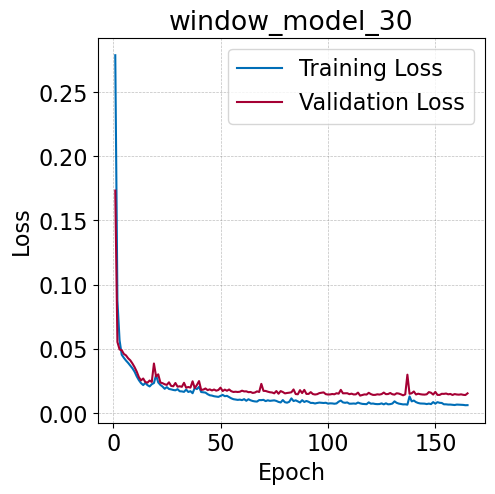

[========================================] 866/866 [100%] in 1.2s (701.91/s)                                            
[========================================] 166/166 [100%] in 0.3s (694.27/s)                                            
Epoch 1/500
9/9 [==============================] - 18s 443ms/step - loss: 0.2560 - mean_absolute_error: 0.4435 - val_loss: 0.0978 - val_mean_absolute_error: 0.2663
Epoch 2/500
9/9 [==============================] - 1s 59ms/step - loss: 0.0745 - mean_absolute_error: 0.2312 - val_loss: 0.0821 - val_mean_absolute_error: 0.2186
Epoch 3/500
9/9 [==============================] - 1s 59ms/step - loss: 0.0600 - mean_absolute_error: 0.1953 - val_loss: 0.0496 - val_mean_absolute_error: 0.2035
Epoch 4/500
9/9 [==============================] - 1s 59ms/step - loss: 0.0514 - mean_absolute_error: 0.2073 - val_loss: 0.0456 - val_mean_absolute_error: 0.1968
Epoch 5/500
9/9 [==============================] - 1s 59ms/step - loss: 0.0471 - mean_absolute_error: 0.1960

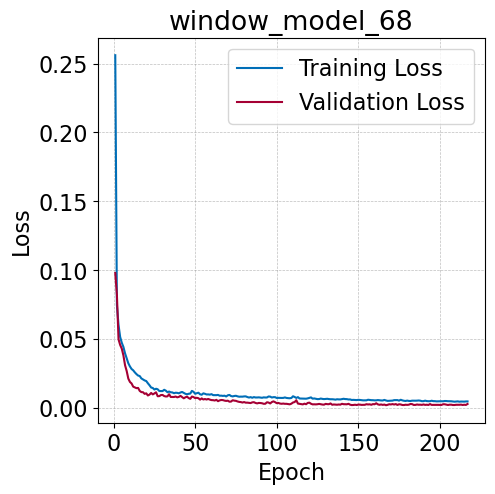

[========================================] 838/838 [100%] in 1.2s (673.75/s)                                            
[========================================] 138/138 [100%] in 0.2s (712.70/s)                                            
Epoch 1/500
9/9 [==============================] - 19s 480ms/step - loss: 0.2588 - mean_absolute_error: 0.4434 - val_loss: 0.1132 - val_mean_absolute_error: 0.2980
Epoch 2/500
9/9 [==============================] - 1s 77ms/step - loss: 0.0712 - mean_absolute_error: 0.2239 - val_loss: 0.0557 - val_mean_absolute_error: 0.1683
Epoch 3/500
9/9 [==============================] - 1s 77ms/step - loss: 0.0620 - mean_absolute_error: 0.1987 - val_loss: 0.0440 - val_mean_absolute_error: 0.1931
Epoch 4/500
9/9 [==============================] - 1s 75ms/step - loss: 0.0531 - mean_absolute_error: 0.2121 - val_loss: 0.0419 - val_mean_absolute_error: 0.1883
Epoch 5/500
9/9 [==============================] - 1s 74ms/step - loss: 0.0470 - mean_absolute_error: 0.1932

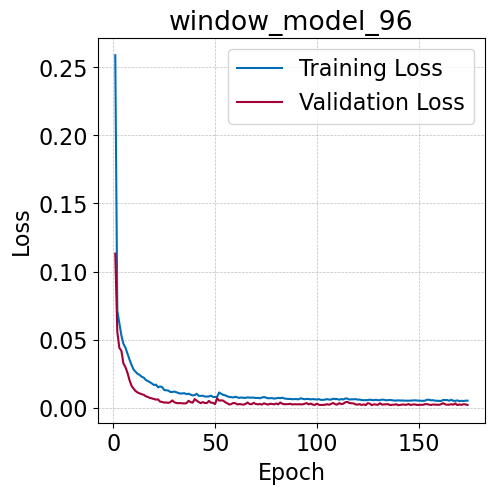

In [41]:
illum_models = []
# window_sizes = [2, 5, 10, 15, 20, 25, 30, 40, 50, 60, 64, 68, 70, 80, 90, 94, 95, 96, 97, 100, 110, 120]
window_sizes = [30, 68, 96]
for window_size in window_sizes:
    train_window_df, train_x, train_y = window_data_base_illumination(train_norm_df, window_size)
    test_window_df, test_x, test_y = window_data_base_illumination(test_norm_df, window_size)
    illum_model = Model(train_x, train_y, test_x, test_y, name=f"window_model_{window_size}")
    illum_model.create_model(
        base_model_layers,
        tf.keras.optimizers.Adam(learning_rate=1e-4),
        tf.keras.losses.MeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError(),
        input_shape=(None, 1),
        output_shape=1,
    )
    # illum_model.run_device = "/CPU:0"

    illum_model.train_model(epochs=500, callbacks=base_early_stopping)
    illum_models.append(illum_model.model)

In [42]:
mu = np.zeros((len(illum_models)), dtype=np.float64)
sigma = np.zeros((len(illum_models)), dtype=np.float64)
for i, model in enumerate(illum_models):
    _, test_x, test_y = window_data_base_illumination(test_norm_df, window_sizes[i])
    actual = denormalize_temperature(test_y, norm_limits)
    predicted = denormalize_temperature(model.predict(test_x, verbose=0).flatten(), norm_limits)
    error = actual - predicted
    _ = kde(error.reshape(-1, 1), labels=[""], plot_kde=False)
    mu[i] = np.mean(error)
    sigma[i] = np.std(error)

[========================================] 204/204 [100%] in 0.4s (548.43/s)                                            
[========================================] 166/166 [100%] in 0.3s (646.68/s)                                            
[========================================] 138/138 [100%] in 0.2s (568.91/s)                                            


ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

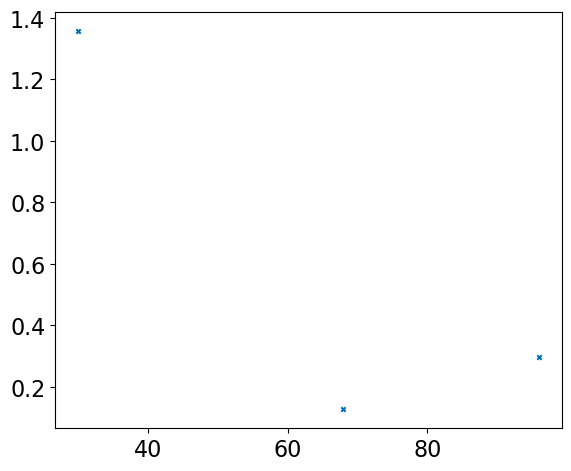

In [43]:
fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
ax.scatter(window_sizes, mu, s=10, color=plt_colors[0], marker="x")
# smoothed line
ax.plot(window_sizes, savgol_filter(mu, 5, 1), color=plt_colors[0], linestyle="--", label="smoothed $\mu$")
twin_ax = ax.twinx()
twin_ax.scatter(window_sizes, sigma, s=10, color=plt_colors[1], marker="x")
# smoothed line
twin_ax.plot(window_sizes, savgol_filter(sigma, 5, 1), color=plt_colors[1], linestyle="--", label="smoothed $\sigma$")

# combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = twin_ax.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)
ax.set_ylabel(r"Mean error ($^\circ C$)", color=plt_colors[0])
twin_ax.set_ylabel(r"Standard deviation ($^\circ C$)", color=plt_colors[1])
ax.tick_params(axis="y", labelcolor=plt_colors[0])
twin_ax.tick_params(axis="y", labelcolor=plt_colors[1])
ax.set_xlabel("Input window size")
ax.grid()

# fig.savefig("../../report/images/chapter-4/funcube-black-panel-illumination-window-size-error.pdf")

plt.show()

In [44]:
print([[i, window_size] for i, window_size in enumerate(window_sizes)])

[[0, 30], [1, 68], [2, 96]]


[========================================] 204/204 [100%] in 0.4s (589.57/s)                                            
Window size: 30
[========================================] 166/166 [100%] in 0.3s (504.69/s)                                            
Window size: 68
[========================================] 138/138 [100%] in 0.3s (552.02/s)                                            
Window size: 96


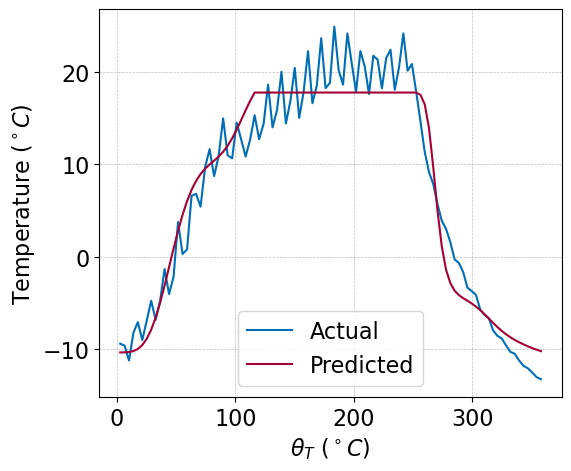

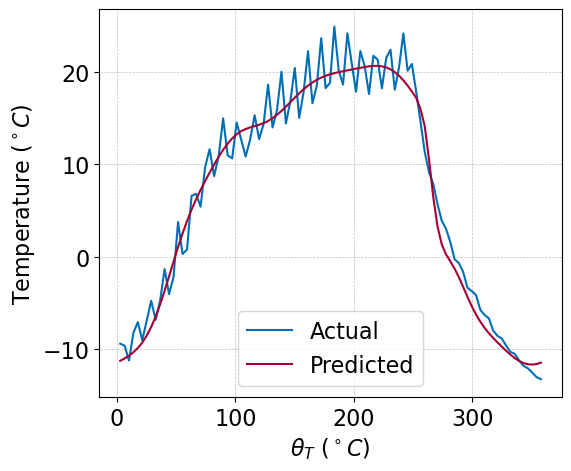

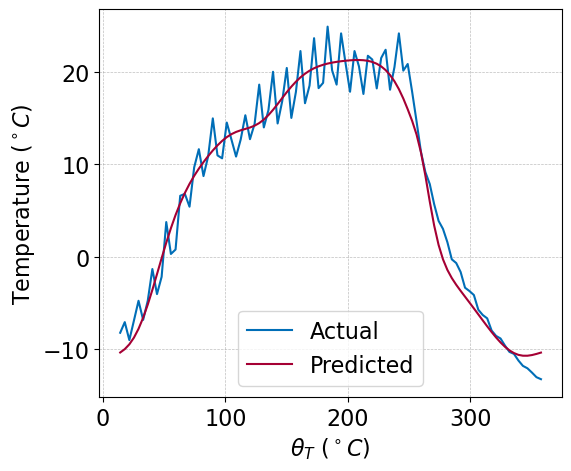

In [45]:
plot_idxs = [0, 1, 2]
for idx in plot_idxs:
    model = illum_models[idx]
    test_window_df, test_x, test_y = window_data_base_illumination(test_norm_df, window_sizes[idx])
    test_window_df = test_window_df.reset_index(drop=True)
    theta_T = test_window_df.iloc[:, 0].to_numpy()
    actual = test_y
    predicted = model.predict(test_x, verbose=0).flatten()
    actual = denormalize_temperature(actual, norm_limits)
    predicted = denormalize_temperature(predicted, norm_limits)
    window_size = window_sizes[idx]
    print(f"Window size: {window_size}")

    try:
        start_index = test_window_df[test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][94]].index[0]
    except:
        start_index = 0
        
    end_index = test_window_df[test_window_df["theta_T"] == test_norm_df["theta_T (deg)"][190]].index[0] + 1
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.plot(theta_T[start_index:end_index], actual[start_index:end_index], color=plt_colors[0], label="Actual")
    ax.plot(theta_T[start_index:end_index], predicted[start_index:end_index], color=plt_colors[1], label="Predicted")
    ax.set_xlabel(r"$\theta_T$ ($^\circ C$)")
    ax.set_ylabel(r"Temperature ($^\circ C$)")
    ax.legend()
    ax.grid()

    fig.savefig(f"../../report/images/chapter-4/funcube-black-panel-illumination-lstm-window-{window_size}.pdf")

[========================================] 195/195 [100%] in 0.3s (669.33/s)                                            
[========================================] 157/157 [100%] in 0.3s (637.09/s)                                            


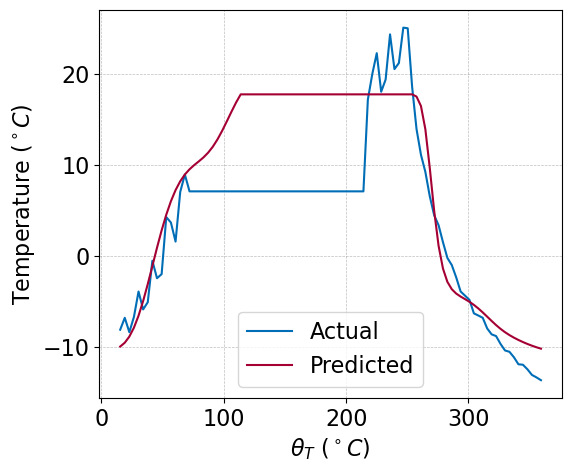

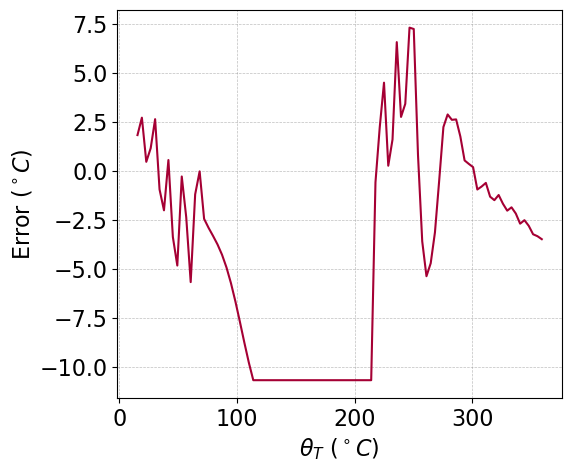

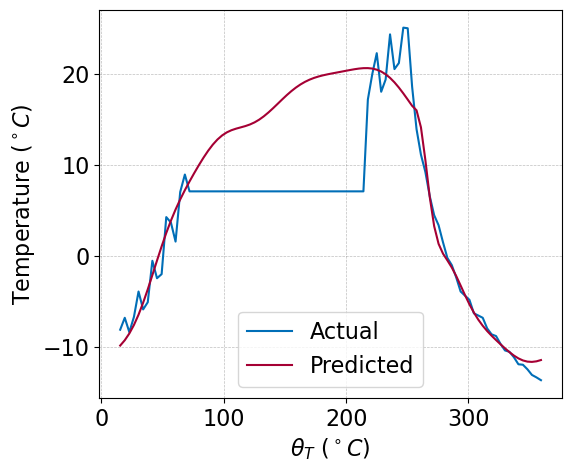

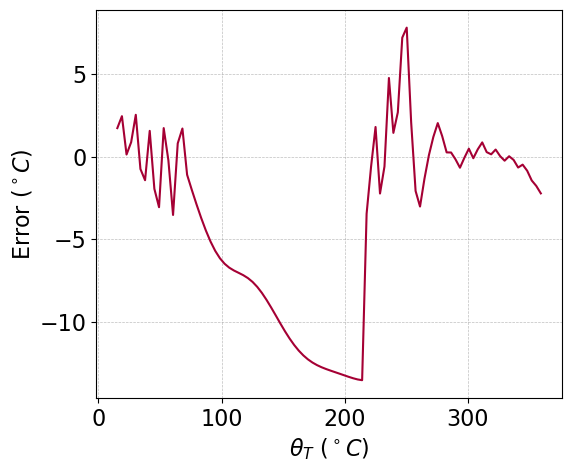

In [46]:
idxs = [0, 1]
for idx in idxs:
    window_size = window_sizes[idx]
    anomaly_windowed_df, anomaly_x, anomaly_y = window_data_base_illumination(anomaly_norm_df, window_sizes[idx])
    theta_T = anomaly_windowed_df.iloc[:, 0].to_numpy()
    actual = denormalize_temperature(anomaly_y, norm_limits)
    predicted = denormalize_temperature(illum_models[idx].predict(anomaly_x, verbose=0).flatten(), norm_limits)
    try:
        start_index = anomaly_windowed_df[anomaly_windowed_df["theta_T"] == anomaly_df["theta_T (deg)"][127]].index[0]
    except:
        start_index = 0
    end_index = anomaly_windowed_df[anomaly_windowed_df["theta_T"] == anomaly_df["theta_T (deg)"][221]].index[0]
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.plot(theta_T[start_index:end_index], actual[start_index:end_index], color=plt_colors[0], label="Actual")
    ax.plot(theta_T[start_index:end_index], predicted[start_index:end_index], color=plt_colors[1], label="Predicted")
    ax.set_xlabel(r"$\theta_T$ ($^\circ C$)")
    ax.set_ylabel(r"Temperature ($^\circ C$)")
    ax.legend()
    ax.grid()
    
    # fig.savefig(f"../report/images/chapter-4/funcube-black-panel-illumination-anomaly-window-{window_size}.pdf")
    
    fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
    ax.plot(theta_T[start_index:end_index], actual[start_index:end_index] - predicted[start_index:end_index], color=plt_colors[1])
    ax.set_xlabel(r"$\theta_T$ ($^\circ C$)")
    ax.set_ylabel(r"Error ($^\circ C$)")
    ax.grid()
    
    # fig.savefig(f"../report/images/chapter-4/funcube-black-panel-illumination-anomaly-window-{window_size}-error.pdf")